In [1]:
!pip3 install dynamax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 1.4 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 MB 22.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 29.1 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 23.2 MB/s eta 0:00:00m eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.0/155.0 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 kB 31.0 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.8-py3-none-any.whl size=1439678 sha256=ce66d291b917fe9021822c47506f22999a09f2d241559c12f212db50797de354
  Sto

In [87]:
#!rm -r Composers

In [88]:
#!tar -xvf Composer_csvs.zip # command to unzip the zip file

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from dynamax.hidden_markov_model import CategoricalHMM
from sklearn.neighbors import NearestCentroid
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
import jax.numpy as jnp
import jax.random as jr
from jax import vmap
from matplotlib import pyplot as plt
import os
import pickle

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
def csv_to_numpy(composer,song):
  main_dir = "./content/Composers"
  df = pd.read_csv(main_dir + '/' + composer + '-output-csvs' + '/' + song)
  return df[['note_num','normed_duration']].to_numpy()

In [3]:
def load_dictionaries(files = ['train.pkl','test.pkl']):
  train_file = files[0]
  test_file = files[1]
  print(train_file)
  with open(train_file,'rb') as f:
    train_dict = pickle.load(f)
  with open(test_file,'rb') as f:
    test_dict = pickle.load(f)

  return train_dict, test_dict

In [4]:
train_dict, test_dict = load_dictionaries()

train.pkl


In [5]:
def get_train_test():
  main_dir = "./content/Composers"
  train_dict = {}
  test_dict = {}

  # NOTE: deleted debussy and balakir for lack of data
  percent_split = 0.8

  for file_name in os.listdir(main_dir):
    comp_list = []
    if file_name[0] == '.':
      continue
    for song in os.listdir(main_dir + '/' + file_name):
      comp_list.append(song)
    np.random.shuffle(comp_list)  # shuffle list
    # manual train-test split
    len_dir = len(comp_list)
    eighty = int(len_dir*percent_split)
    if eighty < 1:
      raise ValueError("Need to rewrite percentsplit!")

    train_dict[file_name.split('-')[0]] = comp_list[:eighty]
    test_dict[file_name.split('-')[0]] = comp_list[eighty:]

    filename = "./content/train.pkl"
  with open(filename, 'wb') as f:
    pickle.dump(train_dict, f)

  filename = "./content/test.pkl"
  with open(filename, 'wb') as f:
    pickle.dump(test_dict, f)


In [6]:
def print_params(params):
    jnp.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
    print("initial probs:")
    print(params.initial.probs)
    print("transition matrix:")
    print(params.transitions.transition_matrix)
    print("emission probs:")
    print(params.emissions.probs) 

Now Let's work with the test set

In [13]:
def ComposerAnalysis(comps_list, train_dict = train_dict, test_dict = test_dict,verbose = True,emissions=2,states=3):
  """function to analyze a list of composers using provided data in a folder at the directory:
  /content/Composers. Each composers song data should be saved as a csv of the format outputted
  by the midi-csv submodule script titled midi_to_csv.py.
  PARAMETERS:

    comps_list (list): list of the names of composers to run the analysis on as they appear in the
        train dictionary and test dictionary
    train_dict (dictionary): dictionary of composer names to a list of the names of the csvs that contain
        the composer's training songs
    test_dict (dictionary): dictionary of composer names to a list of the names of the csvs that contain that
        composer's test songs
    verbose (bool): whether or not to alert user to progress of program

  RETURNS:
    NONE, but prints the scoring of the test set for Nearest Neighbors and K-Means
    """
  main_dir = "./content/Composers"
  # create labels to be used to identify composers
  comp_labels = {composer:i for i, composer in enumerate(comps_list)}

  # 1) go through all the songs we are training on to get the number of unique notes and durations
  # these will be used in the construction of the HMM model
  notes = set()
  durations = set()
  test_songs = 0
  train_songs = 0
  RF_train_songs = []
  RF_test_songs = []
  max_length = 0
  num_composers = 0

  for composer in comps_list:
    for song in test_dict[composer]:
        if len(csv_to_numpy(composer,song)) > max_length:
            max_length = len(csv_to_numpy(composer,song))
        test_songs += 1
            
    for song in train_dict[composer]:
        if len(csv_to_numpy(composer,song)) > max_length:
            max_length = len(csv_to_numpy(composer,song))
        train_songs += 1
    num_composers += 1

  print(max_length)
  print(train_songs)
  print(test_songs)
  RF_train_arr = np.zeros((train_songs,max_length, 2))
  RF_test_arr = np.zeros((test_songs, max_length, 2))


  for composer in comps_list:
    for i, song in enumerate(test_dict[composer]):
      arr = csv_to_numpy(composer,song)
      notes.update(arr[:,0])
      RF_test_arr[i][:(len(arr))] = arr
      durations.update(arr[:,1])
        
    for j, song in enumerate(train_dict[composer]):
      arr = csv_to_numpy(composer,song)
      notes.update(arr[:,0])
      RF_train_arr[j][:(len(arr))] = arr
      durations.update(arr[:,1])
        
        
  RF_train_data = []
  RF_test_data = []

  for song in RF_train_arr:
        RF_train_data.append(np.ravel(song))
        
  for song in RF_test_arr:
        RF_test_data.append(np.ravel(song))
    

  if verbose:
    print(f"The total number of notes found was:\t\t{len(notes)}\nThe "
    f"total number of durations found was:\t{len(durations)}\n\n")

  # 2) Train the an HMM model for each song to get the transition matrix for each song

  num_unique_notes = len(notes)                             # for calculating classes
  num_unique_durations = len(durations)                     # for calculating classes
  num_states = states                                       # dimension of hidden state must be more than num_emmisions. eventually we will grid search this
  num_emmisions = emissions                                 # dimension of observations, two because we have note value and durations
  num_classes = num_unique_notes*num_unique_durations       # total number of values the observation can take on 
  param_list_train = []                                     # place to store the parameter objects
  train_labels = []                                         # labels to now what song was from what composer for
                                                            #   clustering later
  # now training
  if verbose:
    print("NOW STARTING TRAINING\n")
    print(f"\tTotal training songs: {train_songs}\n")

  song_progress = 1

  for composer in comps_list:
    for song in train_dict[composer]:
      if verbose:
        print(f"processing song {song_progress}/{train_songs}")
      song_progress += 1
      train_labels.append(comp_labels[composer])
      arr = csv_to_numpy(composer,song)
      if (np.isnan(arr).any()) or (np.isinf(arr).any()):
          print("NaN or Inf")
          print(np.isnan(arr).any())
          print(np.isinf(arr).any())
          print(" at i =", i)
          continue
      hmm = CategoricalHMM(num_states,num_emmisions,num_classes)   # create object
      params, props = hmm.initialize(method="prior")  
      params, log_probs = hmm.fit_em(params,props,arr,num_iters=10)     # fiting training points
      param_list_train.append(params)                                   # saving parameters for that song
    


  # 3) Processing training data to be used in training classification models
  print("PROCESSING TRAINING DATA\n")

  train_Fmatrix_list = []
  for params in param_list_train:                                       # extracting transition matrices (F matrices)
    train_Fmatrix_list.append(params.transitions.transition_matrix)

  X_for_training = []   
  for matrix in train_Fmatrix_list:                                          # raveling transition matrices so that each
      X_for_training.append(np.ravel(matrix))     # can act as a point in the clustering algorithm


  # 4) Training classification models with processed training data
  if verbose:
    print("TRAINING CLASSIFICATION MODELS\n")

  NC = NearestCentroid()                                                # nearest neighbors classifier
  NC.fit(np.array(X_for_training), train_labels)
  KM = KMeans(len(comps_list))                                                        # KMeans classifier
  KM.fit(np.array(X_for_training), train_labels)
  RF = RandomForestClassifier()
  RF.fit(np.array(X_for_training), train_labels)
  SC = SpectralClustering(len(comps_list))


  # 5) Get the test data by getting transition matrices by running the HMM model on the test points

  print(f"STARTING TEST DATA GENERATION\n")
  print(f"\tTotal test songs: {test_songs}\n")

  param_list_test = []  
  test_labels = []
  song_progress = 0           # to keep track of how much progress in the for loop you've done

  for composer in comps_list:
    for song in test_dict[composer]:
      if verbose:
        print(f"processing test song {song_progress}/{test_songs}")
      song_progress += 1
      test_labels.append(comp_labels[composer])
      arr = csv_to_numpy(composer,song)
      if (np.isnan(arr).any()) or (np.isinf(arr).any()):
          print("NaN or Inf")
          print(np.isnan(arr).any())
          print(np.isinf(arr).any())
          print(" at i =", i)
          continue
      hmm = CategoricalHMM(num_states,num_emmisions,num_classes)
      params, props = hmm.initialize(method="prior")
      params, log_probs = hmm.fit_em(params,props,arr,num_iters=10)
      param_list_test.append(params)

  if verbose:
    print("PROCESSING TEST DATA\n")

  t_matrix_list_test = []
  for params in param_list_test:                # raveling for clustering purposes
      t_matrix_list_test.append(params.transitions.transition_matrix)
  
  X_for_scoring = []                            # place to store ravelled t-matrices of test data for scoring
  for matrix in t_matrix_list_test:
      X_for_scoring.append(np.ravel(matrix))
  
  #return X_for_training, X_for_scoring

  # 6) # Get scores based on the test data
  if verbose:
    print("SCORING PROCESSED TEST DATA\n")

  # nearest neighbors score
  NN_score = NC.score(np.array(X_for_scoring), test_labels)

  # K-means score
  pred_labels = KM.predict(np.array(X_for_scoring))
  KM_score = accuracy_score(test_labels,pred_labels)

  # RF score
  RF_labels = RF.predict(X_for_scoring)
  RF_score = accuracy_score(test_labels,RF_labels)
    
  SC_labels = SC.fit_predict(np.array(X_for_scoring))
  SC_score = accuracy_score(test_labels, SC_labels)

  print(f"RESULTS:\n\nNearest Neighbors Score:\t{NN_score}\nK-Means Score:\t\t{KM_score}\nRF Score:\t\t{RF_score}")
  print(f"Spectral Clustering Score: {SC_score}")
    
    
  RF2 = RandomForestClassifier()
  RF2.fit(list(RF_train_data), train_labels)
  RF2_labels = RF2.predict(RF_test_data)
  RF2_score = accuracy_score(test_labels, RF2_labels)
  print(f"Results of just a normal random forest: {RF2_score}")
    
    
  return X_for_scoring, test_labels


In [14]:
#comps_list = ['haydn','mozart','schubert']
#ComposerAnalysis(comps_list)

In [15]:
new_list = ['chopin','borodin','beeth','liszt','mendelssohn','schumann']

In [16]:
#ComposerAnalysis(new_list)

In [17]:
test_list = ['mozart','chopin','haydn']

In [18]:
for s in [9]:
  F_mats, test_labels = ComposerAnalysis(test_list,states=s,verbose=False)
  print(f"state dimension: {s}")

6241
43
13


PROCESSING TRAINING DATA

STARTING TEST DATA GENERATION

	Total test songs: 13



RESULTS:

Nearest Neighbors Score:	0.46153846153846156
K-Means Score:		0.3076923076923077
RF Score:		0.7692307692307693
Spectral Clustering Score: 0.23076923076923078
Results of just a normal random forest0.7692307692307693
state dimension: 9


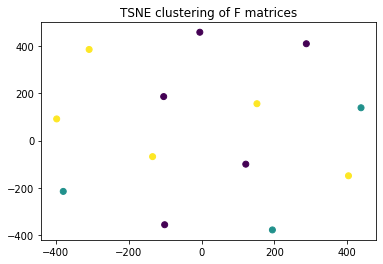

In [92]:
tsne = TSNE(n_components = 2)
results = tsne.fit_transform(F_mats)

plt.scatter(results[:,0], results[:,1], c = test_labels)
plt.title("TSNE clustering of F matrices")
plt.savefig("tsne.png")
plt.show()

In [24]:
os.getcwd()

'/home/murf/Documents/Volume3/Vol3Project'